# Introduction

탐색적 자료 분석을 통해 몇몇 관측값에서 '이상한 값'을 보이는 것을 확인 할 수 있었다.

이번 커널에서는 '이상한 값'을 탐지하여 예측 모델의 성능을 상승시키는 것을 목적으로 한다. 사용 알고리즘은 다음과 같다.

- Isolation Forest

# Import Module

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
train = pd.read_csv('../dataset/train.csv', index_col = 0)
test = pd.read_csv('../dataset/test.csv', index_col = 0)
sample_submission = pd.read_csv('../dataset/sample_submission.csv', index_col = 0)

In [3]:
X_train = train.drop(columns = 'type')
y_train = train['type']

num_X_train = X_train.drop(columns = 'fiberID')
num_X_test = test.drop(columns = 'fiberID')

model = IsolationForest(random_state = 42)
model.fit(num_X_train)

outlier_pred = model.predict(num_X_train)

In [4]:
train['if_outlier'] = outlier_pred

train['if_outlier'].value_counts()

 1    179992
-1     19999
Name: if_outlier, dtype: int64

In [5]:
train_no_outlier = train.loc[train['if_outlier'] == 1]
train_no_outlier.drop(columns = ['if_outlier'], inplace = True)

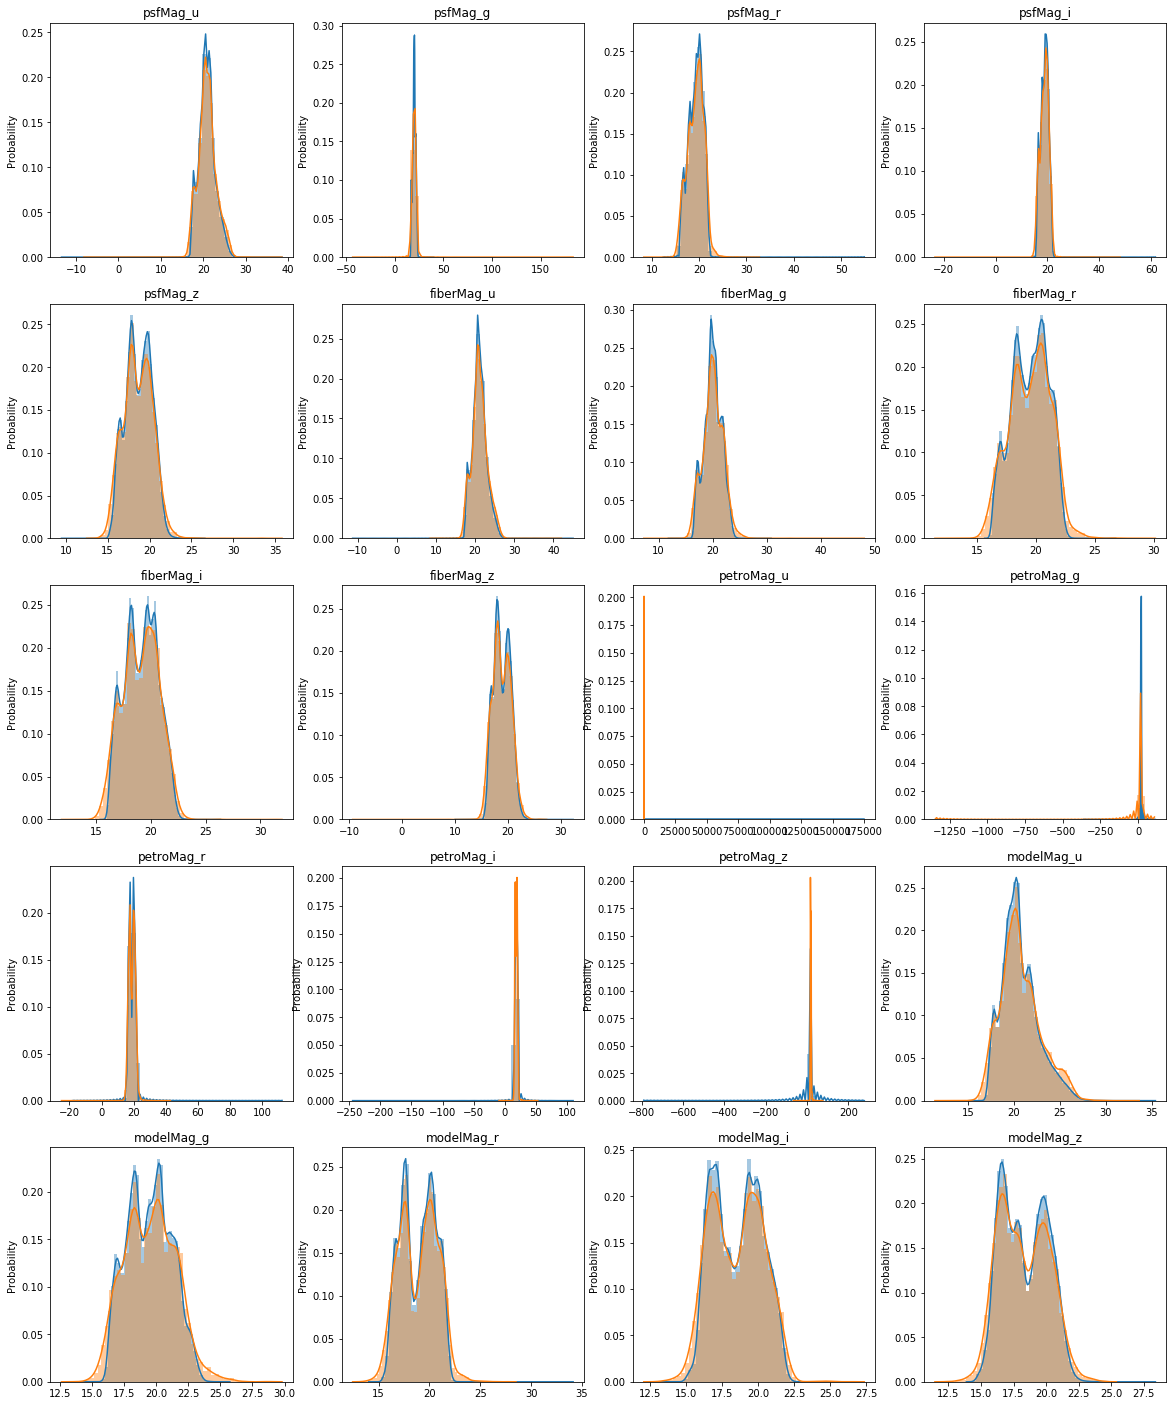

In [6]:
f = plt.figure(figsize = (20,25))

for i, col in enumerate(train_no_outlier.drop(columns = ['type', 'fiberID']).columns):
    f.add_subplot(5, 4, i+1)
    
    sns.distplot(train_no_outlier[col])
    sns.distplot(test[col])
    
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Probability')

Isolation Forest를 이용하여 훈련 데이터에서 Outlier를 제외한결과, 테스트 데이터의 분포와 비슷해졌다는 것을 알 수 있다. 

In [8]:
fiberID_mean = train_no_outlier.groupby('fiberID').mean()
#fiberID_mean.reset_index(inplace = True)

fiberID_median = train_no_outlier.groupby('fiberID').median()
#fiberID_median.reset_index(inplace = True)

fiberID_std = train_no_outlier.groupby('fiberID').std()
#fiberID_std.reset_index(inplace = True)

In [11]:
def VisFeature(data, method = 'hist', sep = False, scale = None):
    
    
    if method == 'hist':
        #data = data.drop(columns = 'fiberID_group')

        f = plt.figure(figsize = (30,30))
        
        for i, col in enumerate(data.columns):
            f.add_subplot(6,4,i+1)
            sns.distplot(data[col])
            plt.title(col, fontsize = 14)
            plt.xlabel(' ')
            plt.ylabel('Density', fontsize = 12)
    
    if method == 'line':
        if sep == False:
            
            #data = data.drop(columns = 'fiberID_group')
        
            f = plt.figure(figsize = (30, 30))
        
            for i, col in enumerate(data.columns):
                f.add_subplot(6, 4, i+1)
                plt.plot(data[col])
                plt.title(col, fontsize = 14)
                plt.xlabel('fiberID Index', fontsize = 12)
                plt.ylabel('Value', fontsize = 12)
                
        elif sep == True:
            
            #data = data.drop(columns = 'fiberID_group')

            f = plt.figure(figsize = (30,30))
            
            for i, col in enumerate(data):
                f.add_subplot(6, 4, i+1)
                plt.plot(data.iloc[:640][col])
                plt.plot(data.iloc[640:][col])
                plt.title(col, fontsize = 14)
                plt.xlabel('fiberID Index', fontsize = 12)
                plt.ylabel('Value', fontsize = 12)

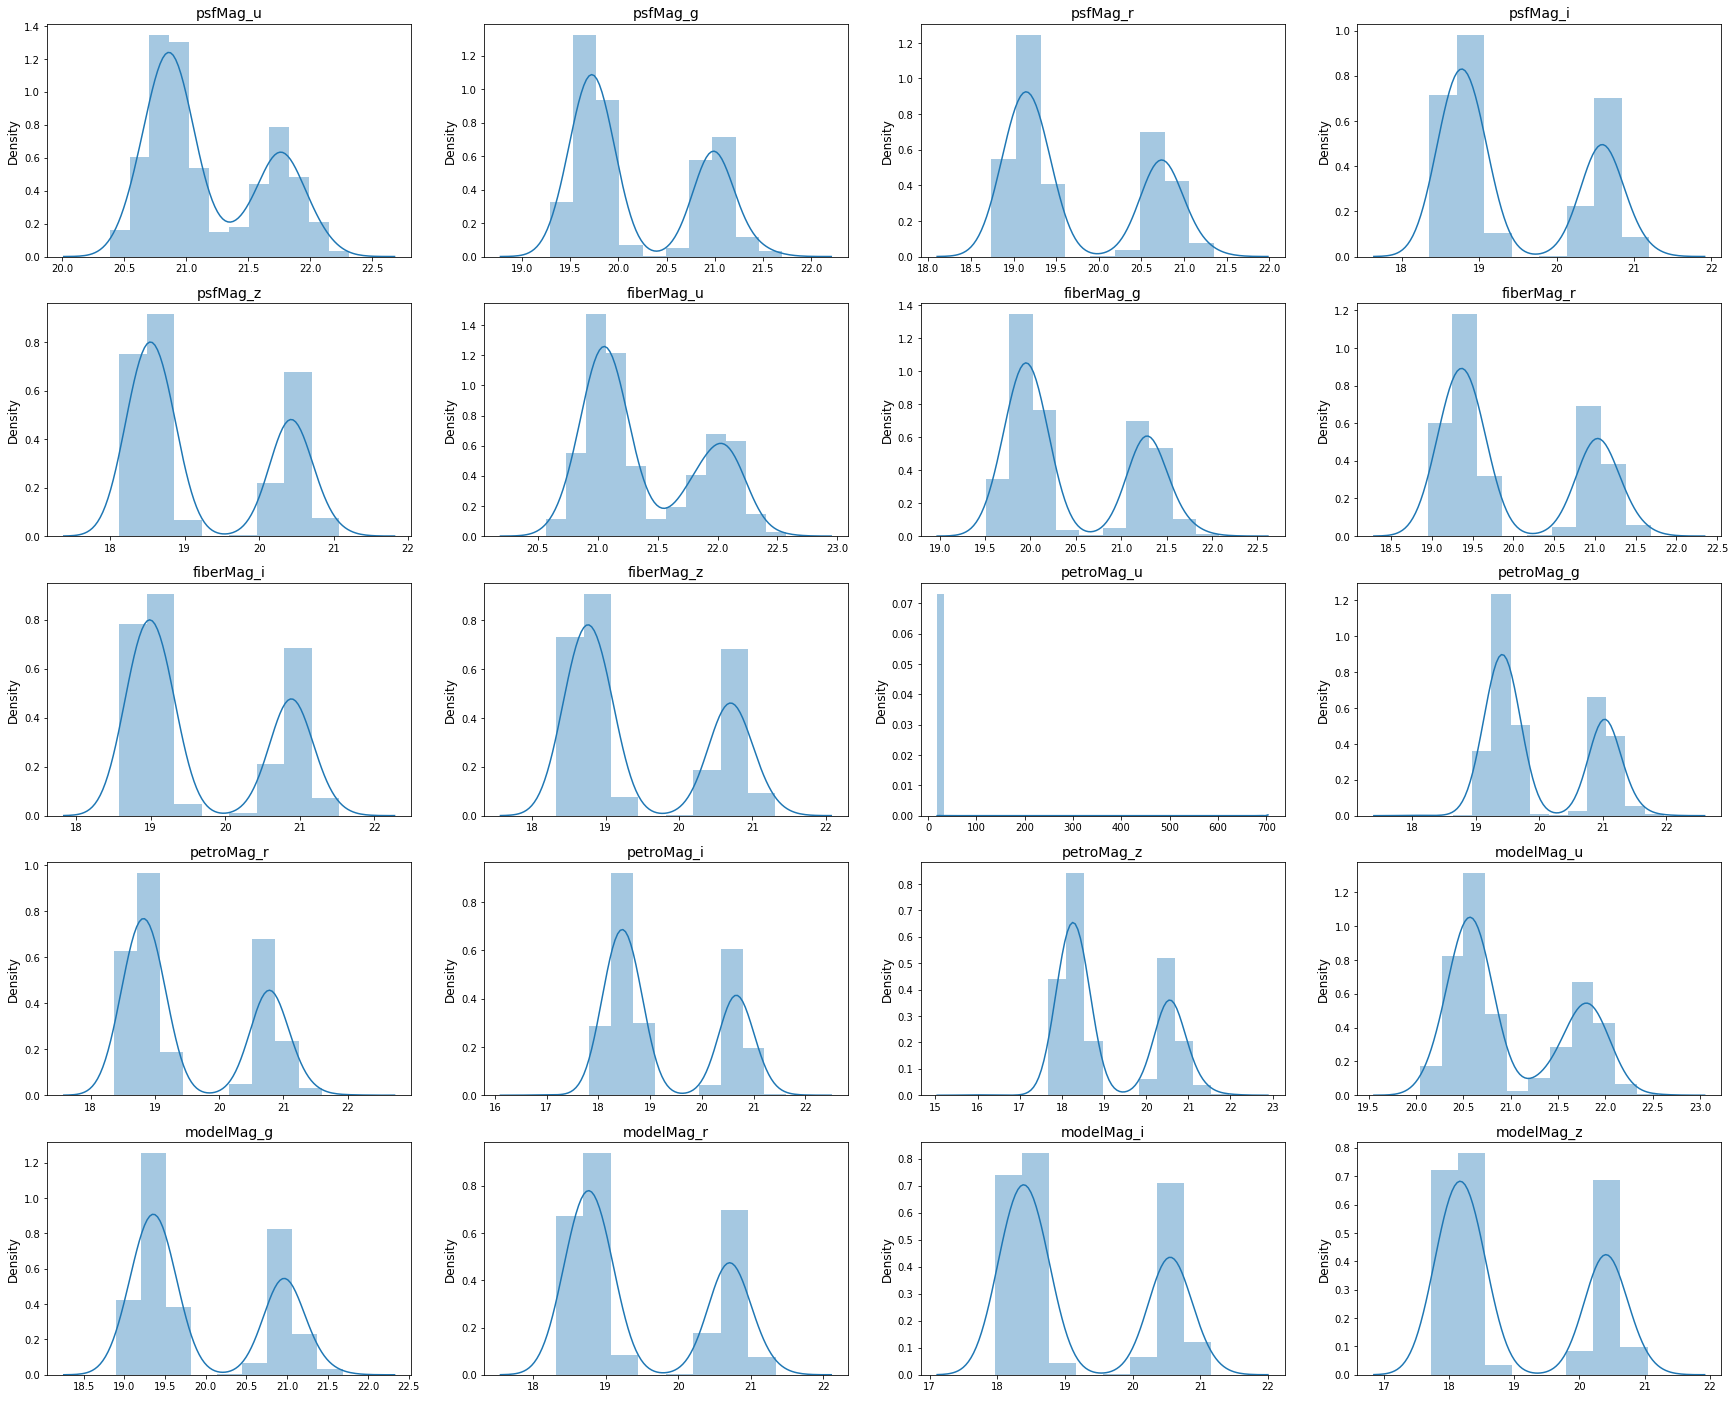

In [12]:
VisFeature(fiberID_mean)

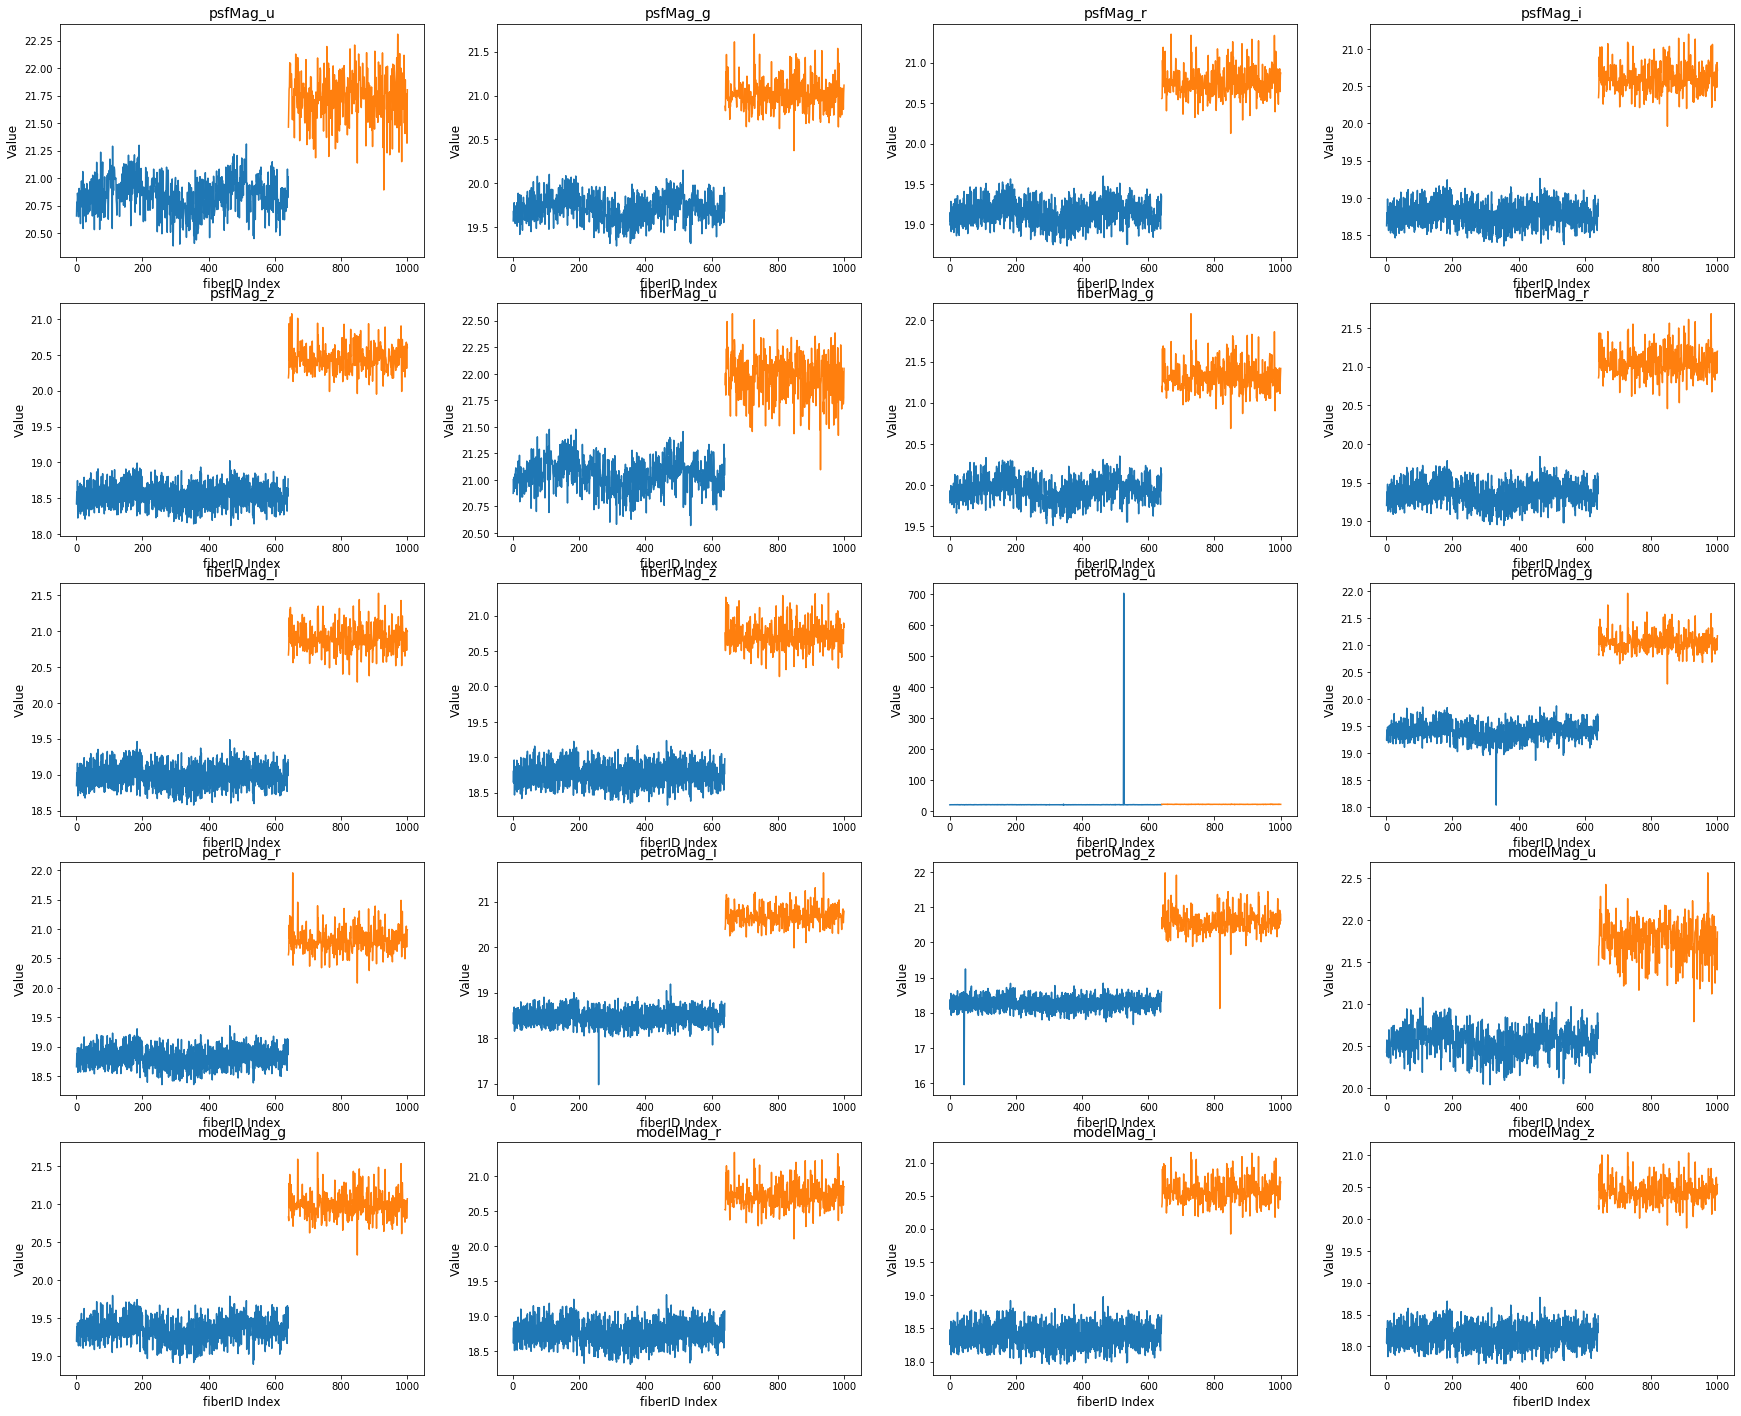

In [16]:
VisFeature(fiberID_mean, method = 'line', sep = True)

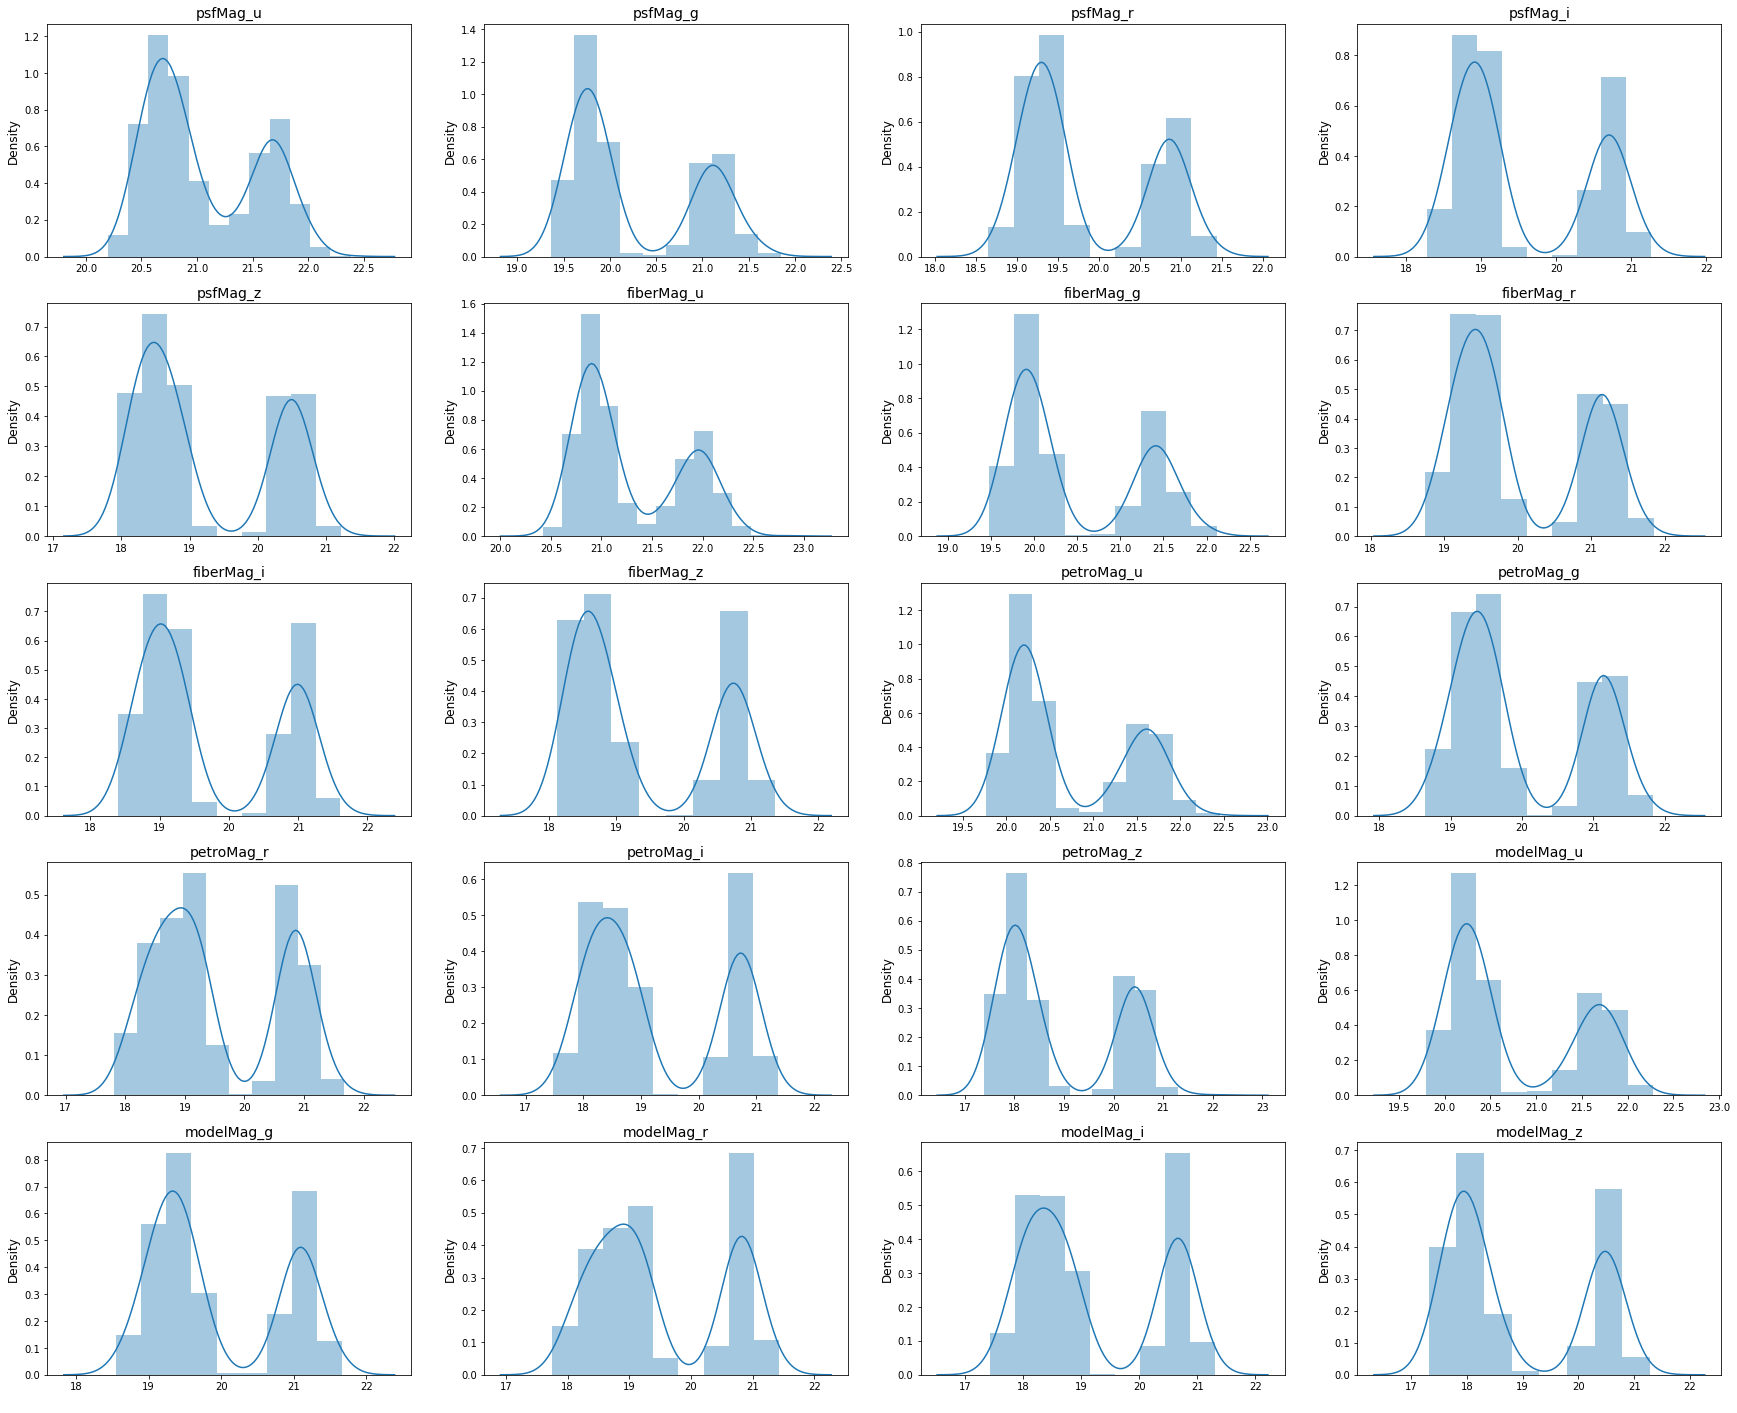

In [13]:
VisFeature(fiberID_median)

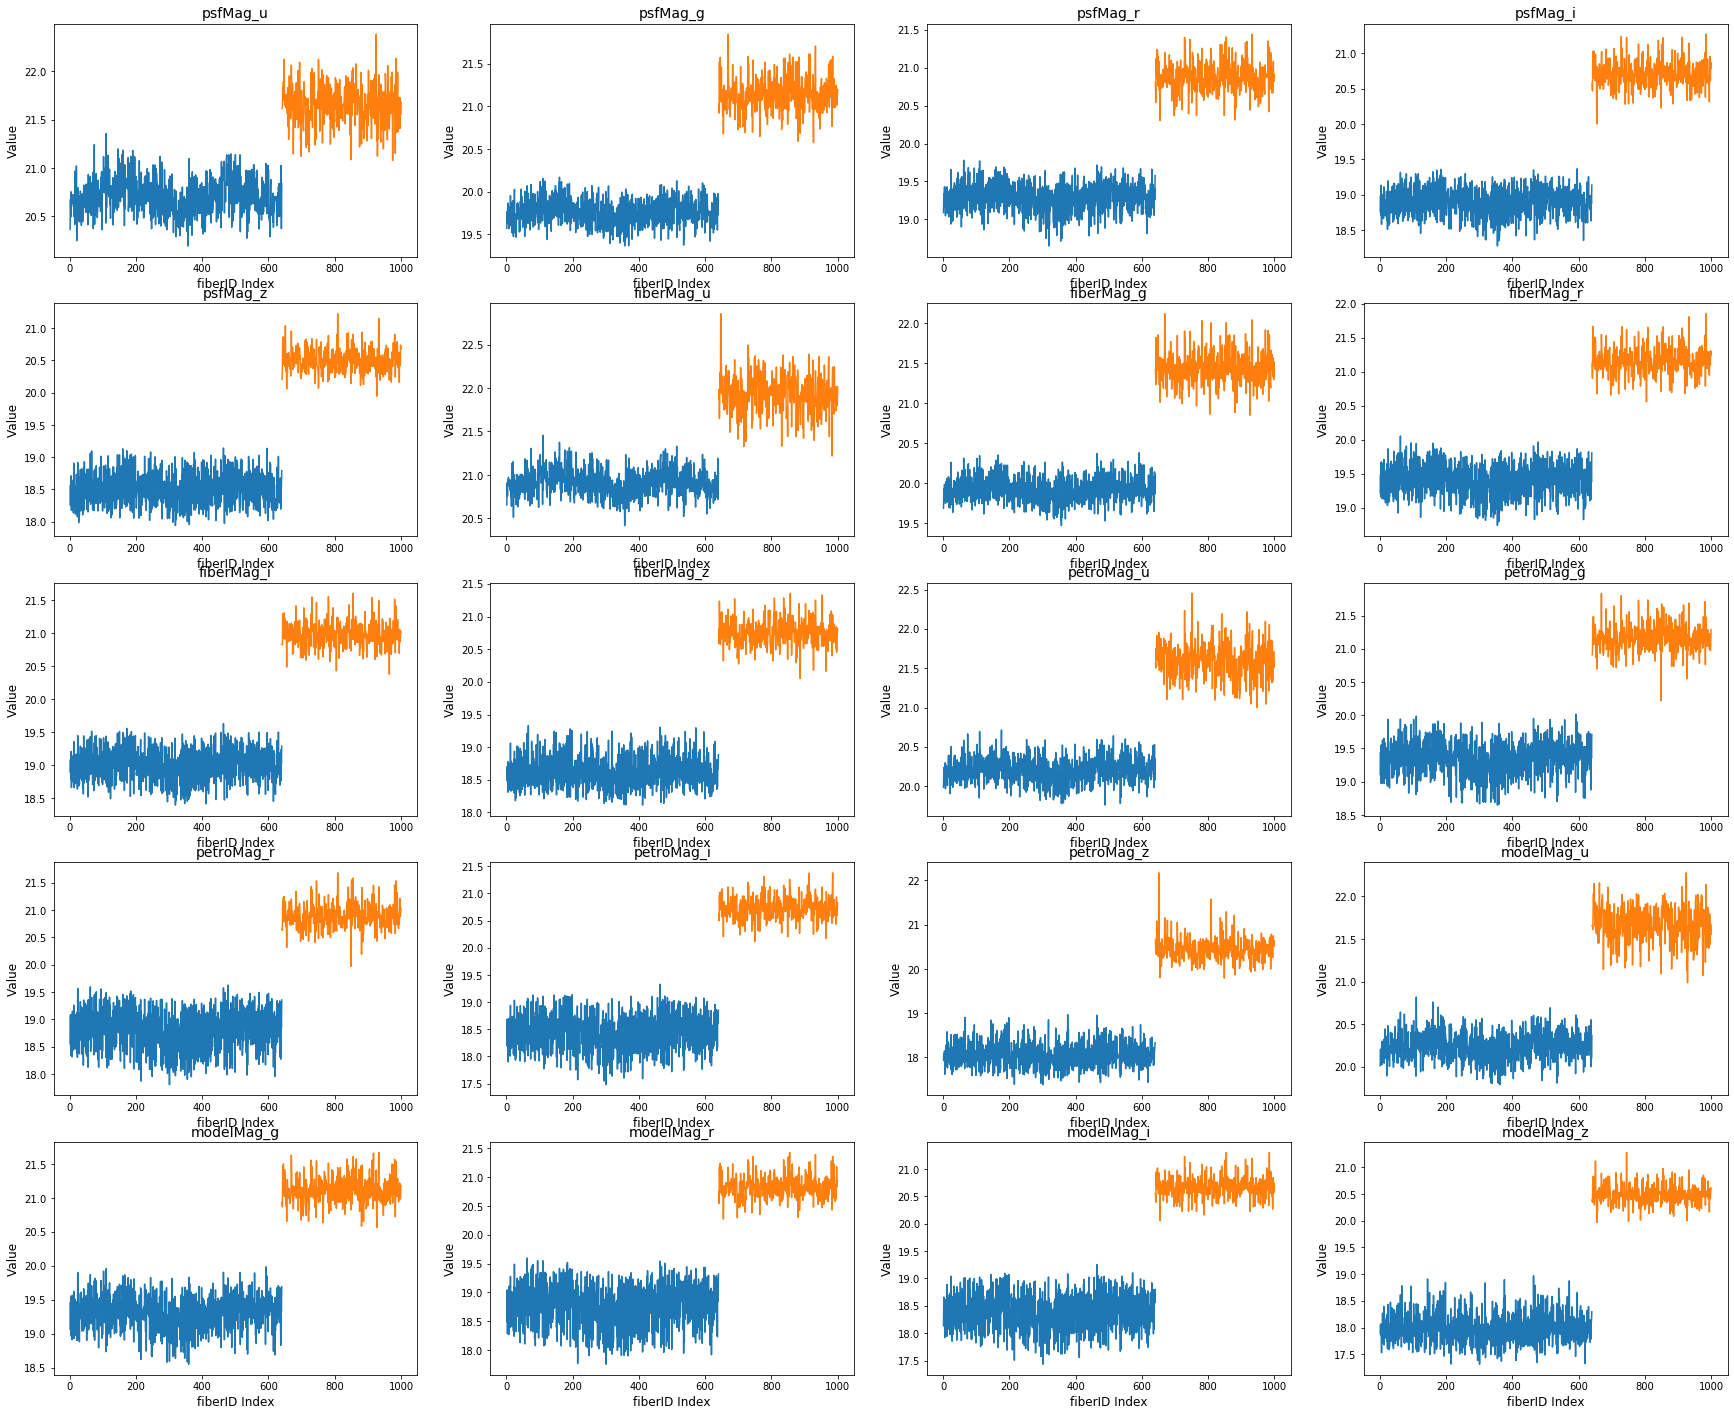

In [17]:
VisFeature(fiberID_median, method = 'line', sep = True)

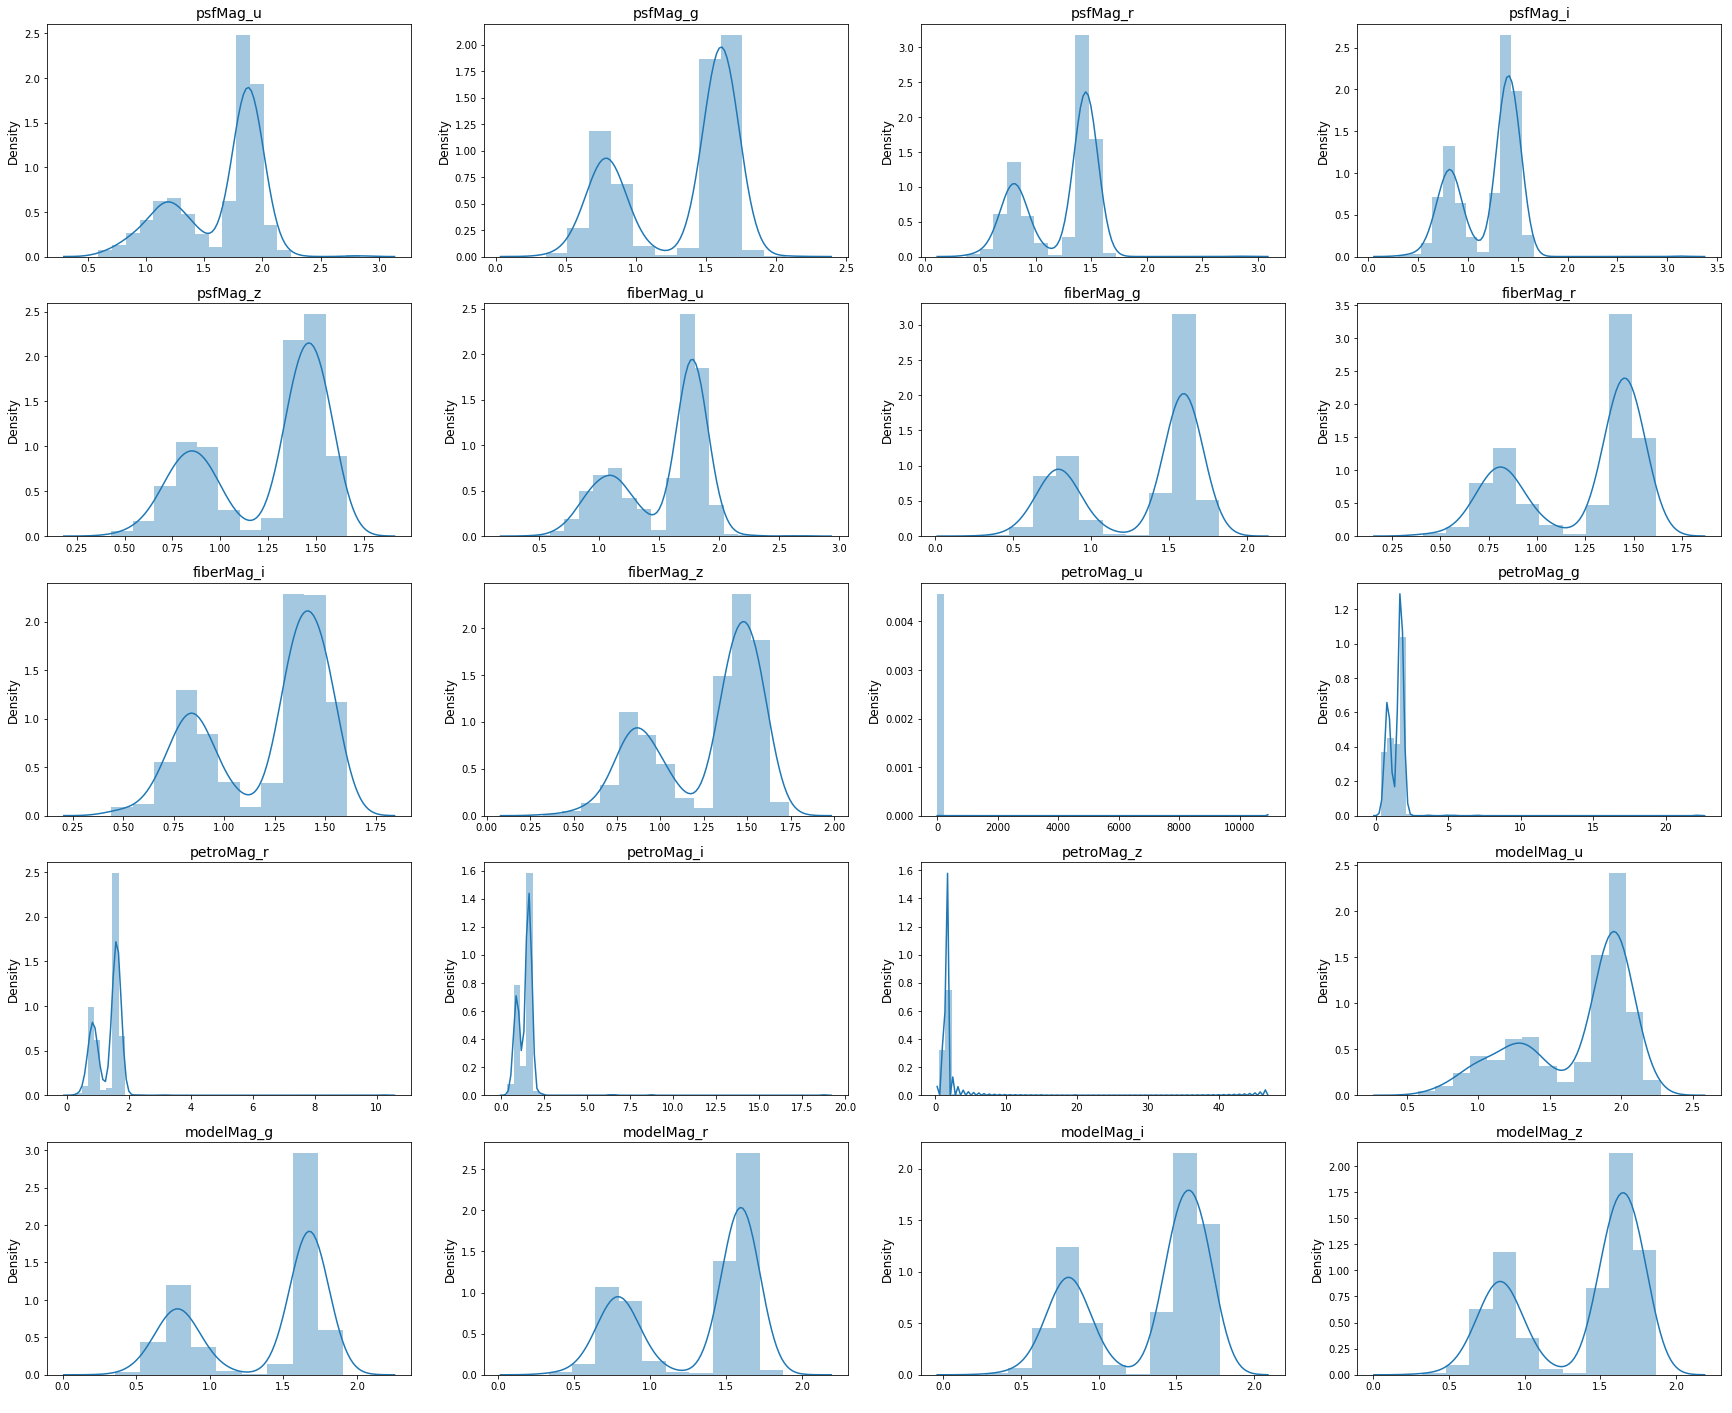

In [14]:
VisFeature(fiberID_std)

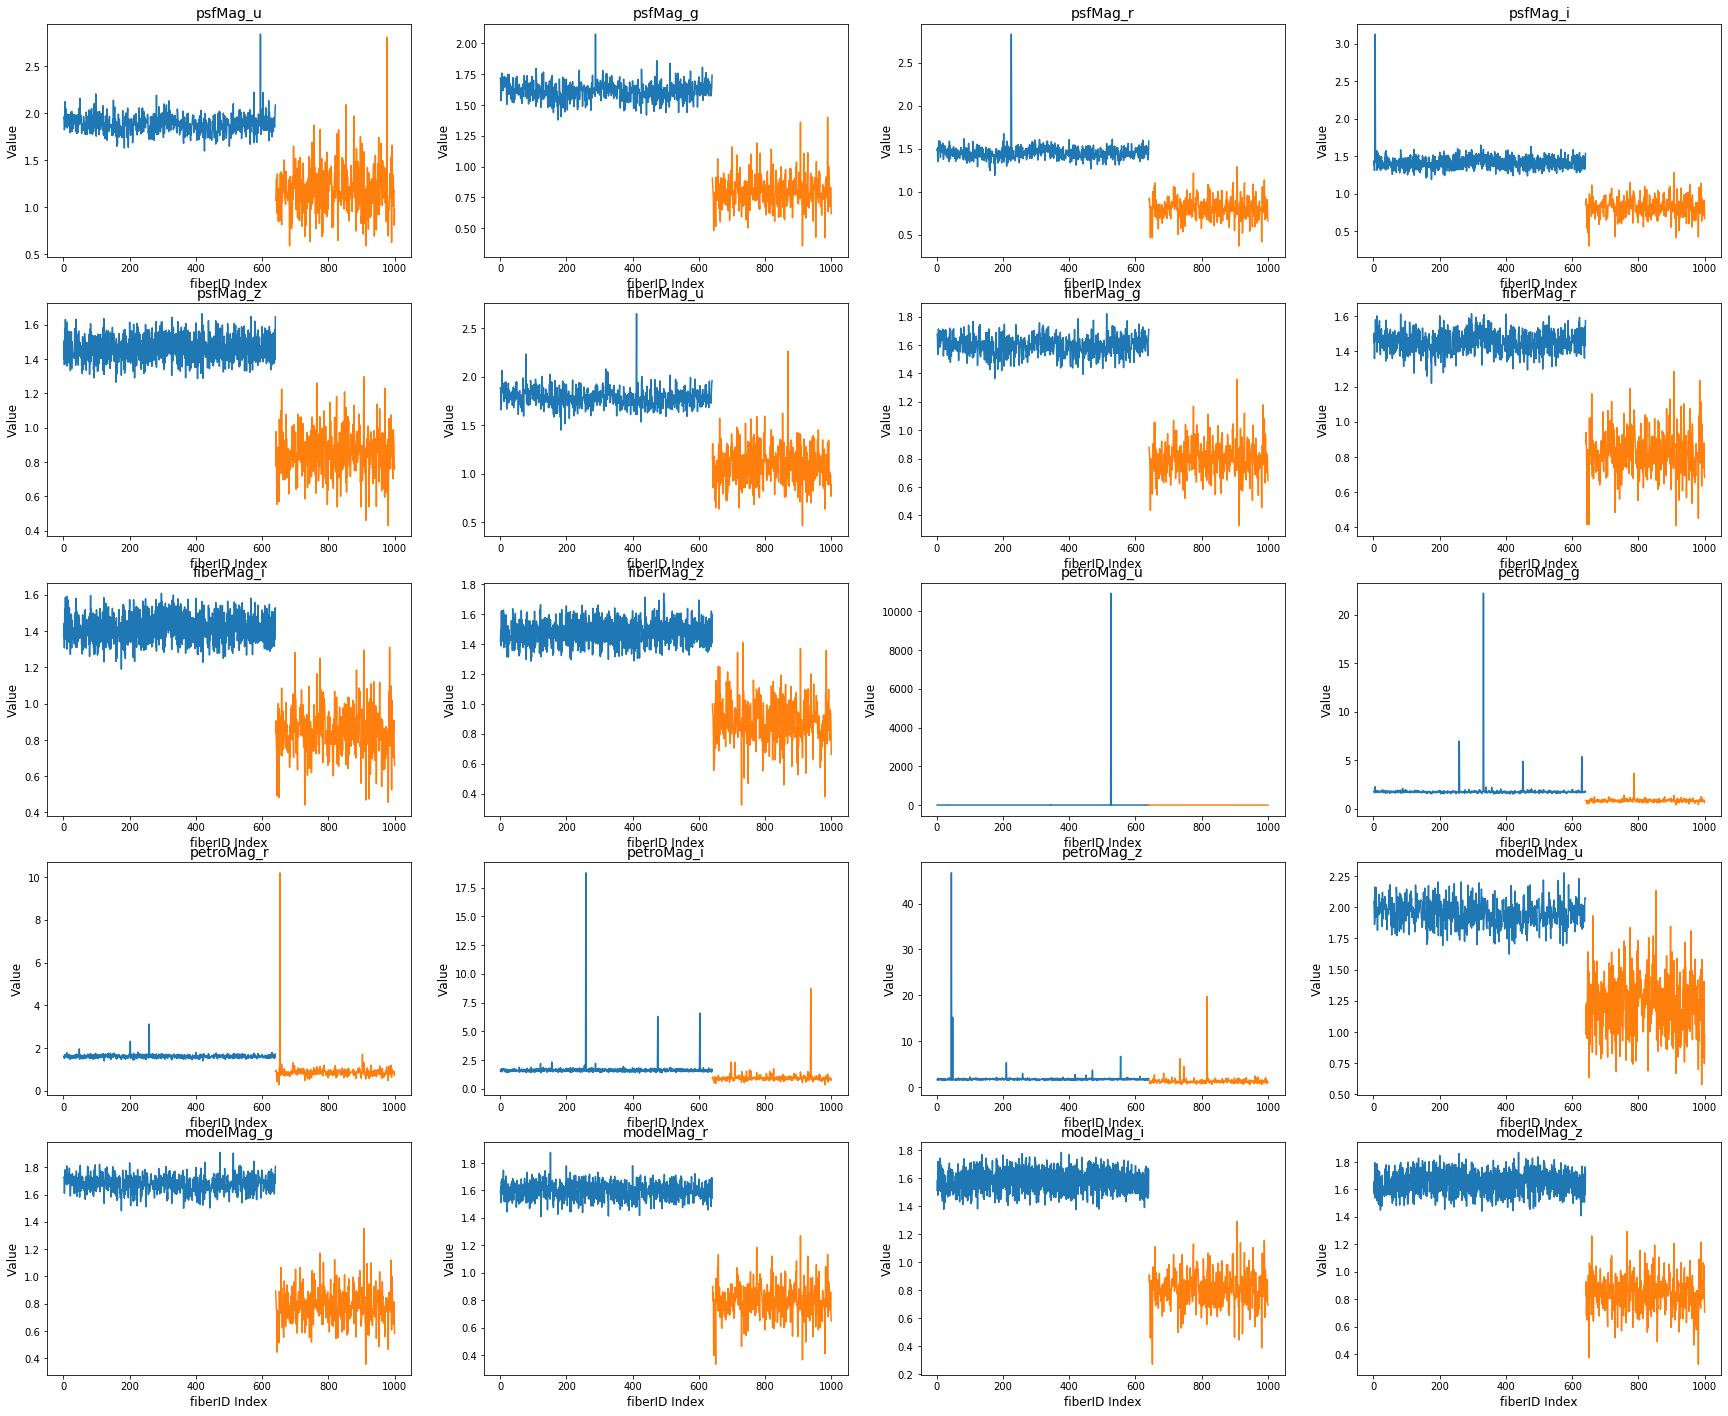

In [18]:
VisFeature(fiberID_std, method = 'line', sep = True)

# k-Means Clustering

In [56]:
X_train = train_no_outlier.drop(columns = 'type')
y_train = train_no_outlier['type']

psfMag_train = X_train[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']]
scaler = StandardScaler()
psfMag_train_scaler = scaler.fit_transform(psfMag_train)

pca = PCA(n_components = 2)
psf_pca = pca.fit_transform(psfMag_train_scaler)
print(pca.explained_variance_ratio_)
psf_pca_scaler_df = pd.DataFrame(psf_pca)

[0.80843808 0.169631  ]


## psfMag

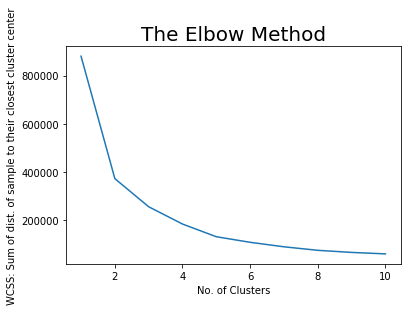

In [59]:
x = psf_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [60]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

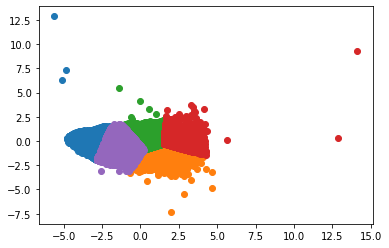

In [61]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1])

plt.show()

In [62]:
train_no_outlier['psf_cluster'] = y_means

In [66]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 0]['type'].value_counts()

SPECTROPHOTO_STD       11316
REDDEN_STD              7342
STAR_BHB                3933
QSO                      706
GALAXY                   696
ROSAT_D                  544
STAR_CATY_VAR            371
STAR_CARBON              350
SERENDIPITY_DISTANT      321
STAR_WHITE_DWARF         191
SERENDIPITY_BLUE         125
SERENDIPITY_FIRST          5
SERENDIPITY_MANUAL         5
STAR_RED_DWARF             1
Name: type, dtype: int64

In [67]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 1]['type'].value_counts()

STAR_RED_DWARF         10134
GALAXY                  5262
SERENDIPITY_FIRST       3273
QSO                     2311
ROSAT_D                 1704
STAR_CARBON              920
STAR_SUB_DWARF           661
SERENDIPITY_RED           61
SERENDIPITY_DISTANT       16
SERENDIPITY_MANUAL        14
STAR_WHITE_DWARF           9
SERENDIPITY_BLUE           3
STAR_CATY_VAR              2
Name: type, dtype: int64

In [69]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 2]['type'].value_counts()

SERENDIPITY_BLUE       19851
QSO                    12651
GALAXY                  7138
STAR_BHB                3853
SERENDIPITY_DISTANT     3393
SERENDIPITY_FIRST       2152
ROSAT_D                 1941
STAR_WHITE_DWARF        1398
STAR_CATY_VAR            229
STAR_CARBON              207
SERENDIPITY_MANUAL        18
STAR_PN                   10
SERENDIPITY_RED            2
STAR_RED_DWARF             2
Name: type, dtype: int64

In [70]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 3]['type'].value_counts()

QSO                    26265
SERENDIPITY_BLUE        1416
SERENDIPITY_FIRST       1319
ROSAT_D                  790
GALAXY                   382
SERENDIPITY_DISTANT      363
STAR_RED_DWARF             5
STAR_BHB                   5
SERENDIPITY_MANUAL         5
STAR_WHITE_DWARF           3
SERENDIPITY_RED            2
STAR_PN                    1
Name: type, dtype: int64

In [71]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 4]['type'].value_counts()

GALAXY                 21562
REDDEN_STD              7271
STAR_CATY_VAR           4942
STAR_BHB                4326
QSO                     3628
STAR_CARBON             1554
ROSAT_D                  991
STAR_SUB_DWARF           441
STAR_WHITE_DWARF         430
SERENDIPITY_DISTANT      346
STAR_RED_DWARF           320
SERENDIPITY_BLUE         287
SERENDIPITY_FIRST        211
STAR_BROWN_DWARF           3
SERENDIPITY_MANUAL         3
Name: type, dtype: int64

## fiberMag

In [83]:
fiberMag_train = X_train[['fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z']]

scaler = StandardScaler()
fiberMag_train_scaler = scaler.fit_transform(fiberMag_train)

pca = PCA(n_components = 2)
fiber_pca = pca.fit_transform(fiberMag_train_scaler)
print(pca.explained_variance_ratio_)
fiber_pca_scaler_df = pd.DataFrame(fiber_pca)

[0.80696092 0.17133229]


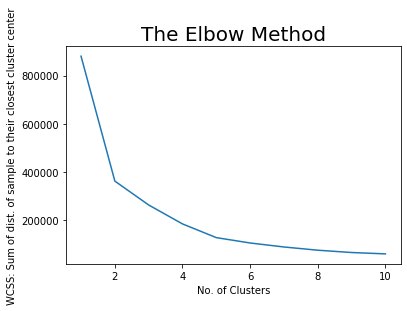

In [84]:
x = fiber_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [85]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

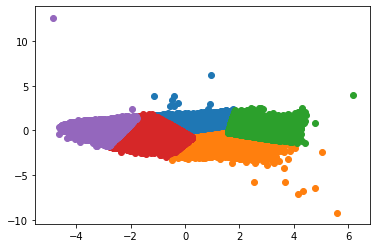

In [86]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1])

plt.show()

In [75]:
train_no_outlier['fiber_cluster'] = y_means

In [76]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 0]['type'].value_counts()

SERENDIPITY_BLUE       19801
QSO                    12628
STAR_BHB                4108
SERENDIPITY_DISTANT     3405
GALAXY                  2221
ROSAT_D                 2021
SERENDIPITY_FIRST       1983
STAR_WHITE_DWARF        1427
STAR_CATY_VAR            229
STAR_CARBON              173
SERENDIPITY_MANUAL        18
STAR_PN                   10
STAR_RED_DWARF             4
SERENDIPITY_RED            2
Name: type, dtype: int64

In [77]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 1]['type'].value_counts()

STAR_RED_DWARF         10186
GALAXY                  4312
SERENDIPITY_FIRST       3771
QSO                     2223
ROSAT_D                 1792
STAR_CARBON             1067
STAR_SUB_DWARF           728
SERENDIPITY_RED           59
SERENDIPITY_MANUAL        16
SERENDIPITY_DISTANT       15
STAR_WHITE_DWARF          14
STAR_CATY_VAR              2
SERENDIPITY_BLUE           2
Name: type, dtype: int64

In [78]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 2]['type'].value_counts()

QSO                    26128
SERENDIPITY_BLUE        1501
SERENDIPITY_FIRST        793
ROSAT_D                  513
SERENDIPITY_DISTANT      390
GALAXY                    23
STAR_RED_DWARF             5
SERENDIPITY_RED            4
SERENDIPITY_MANUAL         3
STAR_WHITE_DWARF           2
STAR_PN                    1
Name: type, dtype: int64

In [79]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 3]['type'].value_counts()

GALAXY                 26807
REDDEN_STD              7582
STAR_CATY_VAR           5168
STAR_BHB                4141
QSO                     3828
STAR_CARBON             1492
ROSAT_D                 1113
SERENDIPITY_FIRST        408
STAR_WHITE_DWARF         398
STAR_SUB_DWARF           374
SERENDIPITY_DISTANT      304
STAR_RED_DWARF           267
SERENDIPITY_BLUE         249
STAR_BROWN_DWARF           3
SERENDIPITY_MANUAL         3
Name: type, dtype: int64

In [80]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 4]['type'].value_counts()

SPECTROPHOTO_STD       11316
REDDEN_STD              7031
STAR_BHB                3868
GALAXY                  1677
QSO                      754
ROSAT_D                  531
SERENDIPITY_DISTANT      325
STAR_CARBON              299
STAR_WHITE_DWARF         190
STAR_CATY_VAR            145
SERENDIPITY_BLUE         129
SERENDIPITY_FIRST          5
SERENDIPITY_MANUAL         5
Name: type, dtype: int64

## petroMag

In [87]:
petroMag_train = X_train[['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z']]

scaler = StandardScaler()
petroMag_train_scaler = scaler.fit_transform(petroMag_train)

pca = PCA(n_components = 2)
petro_pca = pca.fit_transform(petroMag_train_scaler)
print(pca.explained_variance_ratio_)
petro_pca_scaler_df = pd.DataFrame(petro_pca)

[0.58012255 0.20000103]


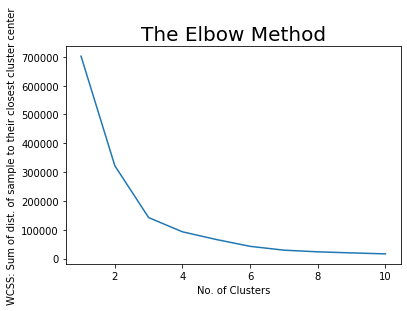

In [88]:
x = petro_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [89]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

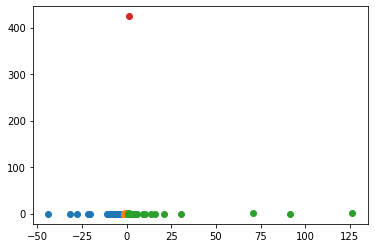

In [90]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])

plt.show()

## modelMag

In [91]:
modelMag_train = X_train[['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']]

scaler = StandardScaler()
modelMag_train_scaler = scaler.fit_transform(modelMag_train)

pca = PCA(n_components = 2)
model_pca = pca.fit_transform(modelMag_train_scaler)
print(pca.explained_variance_ratio_)
model_pca_scaler_df = pd.DataFrame(model_pca)

[0.82318863 0.1585945 ]


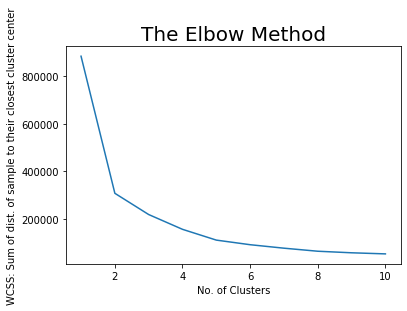

In [92]:
x = model_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [94]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

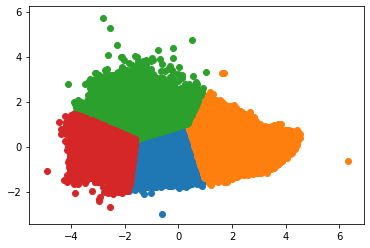

In [96]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])

plt.show()

In [98]:
train_no_outlier['model_cluster'] = y_means

In [99]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 0]['type'].value_counts()

SERENDIPITY_BLUE       19371
QSO                    12850
STAR_BHB                5935
SERENDIPITY_DISTANT     3401
SERENDIPITY_FIRST       2382
ROSAT_D                 2317
STAR_WHITE_DWARF        1614
STAR_CARBON              427
GALAXY                   397
STAR_CATY_VAR            262
REDDEN_STD                65
SERENDIPITY_MANUAL        18
STAR_PN                    9
SERENDIPITY_RED            2
STAR_SUB_DWARF             2
Name: type, dtype: int64

In [100]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 1]['type'].value_counts()

GALAXY                 31119
REDDEN_STD             14548
SPECTROPHOTO_STD       11316
STAR_BHB                6172
STAR_CATY_VAR           5277
QSO                     2613
ROSAT_D                 1299
STAR_CARBON             1143
SERENDIPITY_DISTANT      489
SERENDIPITY_FIRST        404
STAR_WHITE_DWARF         394
SERENDIPITY_BLUE         266
STAR_SUB_DWARF           107
STAR_RED_DWARF            44
SERENDIPITY_MANUAL         8
STAR_PN                    1
Name: type, dtype: int64

In [101]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 2]['type'].value_counts()

STAR_RED_DWARF         10413
SERENDIPITY_FIRST       3520
GALAXY                  3489
QSO                     2322
ROSAT_D                 1849
STAR_CARBON             1461
STAR_SUB_DWARF           993
SERENDIPITY_RED           61
STAR_WHITE_DWARF          20
SERENDIPITY_MANUAL        16
SERENDIPITY_DISTANT       15
STAR_CATY_VAR              5
STAR_BROWN_DWARF           3
SERENDIPITY_BLUE           3
Name: type, dtype: int64

In [102]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 3]['type'].value_counts()

QSO                    27776
SERENDIPITY_BLUE        2042
SERENDIPITY_FIRST        654
SERENDIPITY_DISTANT      534
ROSAT_D                  505
GALAXY                    35
STAR_BHB                  10
STAR_RED_DWARF             5
STAR_WHITE_DWARF           3
SERENDIPITY_MANUAL         3
SERENDIPITY_RED            2
STAR_PN                    1
Name: type, dtype: int64

In [104]:
train_no_outlier.to_csv('../dataset/del_outlier_clustering_train.csv')